# Setup

In [1]:
# When working in AI LRZq
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%run analysis_setup_cp.ipynb

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2
The data has N = 900 rows and N = 14 columns.


## Prepare Data


In [3]:
import pandas as pd
from pathlib import Path

RUN_TO_ANALYSE = "14"
CP_DIR = Path("output") / "runs" / str(RUN_TO_ANALYSE)

df_agg = pd.read_csv(CP_DIR / "combined_cp_metrics.csv")

In [4]:
df_agg.head()

,universe_id,universe_training_year,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups,q_hat,coverage,avg_size,cov_frau1,cov_nongerman,cov_nongerman_male,cov_nongerman_female
0,29bbfc090457b375162cd6d5988a0c0d,2010_14,1k,scale,rf,nationality-sex,drop-non-german,0.640000,0.913900,1.149827,0.911336,0.902824,0.923264,0.869001
1,f7207e98f9209b278fafa387f90cc17e,2010_14,25k,scale,rf,nationality-sex,drop-non-german,0.650000,0.914335,1.140999,0.912684,0.908774,0.923444,0.884501
2,621e12d5accc50ee57a82fe038d6e66d,2012_14,1k,do-not-scale,elasticnet,nationality-sex,keep-all,0.697848,0.911860,1.232828,0.909179,0.945209,0.955327,0.928465
3,523b4d52292fbf0322ce0d3ad7b649bd,2014,1k,do-not-scale,elasticnet,none,drop-non-german,0.677181,0.910144,1.251577,0.909476,0.947679,0.956859,0.932489
4,346c04ceb92e7cd7c01293712a413e02,2012_14,5k,do-not-scale,penalized_logreg,age,keep-all,0.665430,0.912596,1.250184,0.909341,0.960141,0.967396,0.948137


In [5]:
df_agg.shape

(900, 14)

In [6]:
main_cp_metric = "avg_size" # "avg_size", "cov_nongerman_female"

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [7]:
cols_design_dec = ["universe_training_year", 
                   "universe_training_size", 
                   "universe_scale",
                   "universe_model", 
                   "universe_exclude_features", 
                   "universe_exclude_subgroups"]
X = df_agg[cols_design_dec]
y = df_agg[main_cp_metric]

In [8]:
X.head()

,universe_training_year,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups
0,2010_14,1k,scale,rf,nationality-sex,drop-non-german
1,2010_14,25k,scale,rf,nationality-sex,drop-non-german
2,2012_14,1k,do-not-scale,elasticnet,nationality-sex,keep-all
3,2014,1k,do-not-scale,elasticnet,none,drop-non-german
4,2012_14,5k,do-not-scale,penalized_logreg,age,keep-all


In [9]:
X.shape

(900, 6)

In [10]:
y.shape

(900,)

### Main Effects of Settings Only (i.e. no interactions)

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), 
).fit(X) 
X_processed = preprocessor.transform(X) 

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data

0.678858679193476

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [12]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())

Weight?,Feature
+1.146,<BIAS>
+0.054,universe_training_size_1k
+0.025,universe_scale_do-not-scale
+0.018,universe_exclude_features_age
+0.018,universe_model_logreg
+0.018,universe_model_penalized_logreg
+0.006,universe_exclude_subgroups_drop-non-german
+0.001,universe_training_year_2010_14
-0.000,universe_scale_scale
-0.000,universe_exclude_subgroups_keep-all


### Including Interactions

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data

0.9009535239145172

Weights of importance:

In [14]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())

Weight?,Feature
+1.151,<BIAS>
+0.040,universe_scale_do-not-scale universe_model_penalized_logreg
+0.040,universe_scale_do-not-scale universe_model_logreg
+0.038,universe_training_size_1k
+0.031,universe_scale_do-not-scale universe_exclude_features_age
+0.031,universe_training_size_1k universe_scale_scale
+0.023,universe_training_size_1k universe_model_elasticnet
+0.019,universe_model_elasticnet universe_exclude_features_age
+0.010,universe_training_size_1k universe_exclude_subgroups_drop-non-german
+0.005,universe_training_year_2012_14 universe_training_size_1k


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [15]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[cols_design_dec], outcome = df_agg[main_cp_metric])

In [16]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
universe_exclude_features,0.023835,0.023835,0.002201,0.002201
universe_exclude_subgroups,0.004639,0.004639,0.000552,0.000552
universe_model,0.244509,0.244509,0.003597,0.003597
universe_scale,0.067441,0.067441,0.002607,0.002607
universe_training_size,0.333231,0.333231,0.004227,0.004227
universe_training_year,0.000716,0.000716,0.000196,0.000196


In [17]:
m_fanova.quantify_importance(save_to = CP_DIR/ f"fanova_importance_interactions-overall_{main_cp_metric}.csv")

,level_0,level_1,level_2,level_3,level_4,level_5,individual importance,total importance,individual std,total std
4,universe_training_size,NaN,NaN,NaN,NaN,NaN,0.333231,0.333231,0.004227,0.004227
2,universe_model,NaN,NaN,NaN,NaN,NaN,0.244509,0.244509,0.003597,0.003597
16,universe_model,universe_training_size,NaN,NaN,NaN,NaN,0.073954,0.651693,0.002680,0.007198
3,universe_scale,NaN,NaN,NaN,NaN,NaN,0.067441,0.067441,0.002607,0.002607
15,universe_model,universe_scale,NaN,NaN,NaN,NaN,0.056446,0.368395,0.002257,0.005161
...,...,...,...,...,...,...,...,...,...,...
44,universe_exclude_features,universe_exclude_subgroups,universe_scale,universe_training_size,NaN,NaN,0.000141,0.502012,0.000094,0.004352
29,universe_exclude_features,universe_scale,universe_training_year,NaN,NaN,NaN,0.000140,0.109662,0.000099,0.005815
45,universe_exclude_features,universe_exclude_subgroups,universe_scale,universe_training_year,NaN,NaN,0.000120,0.116276,0.000118,0.005919
14,universe_exclude_subgroups,universe_training_year,NaN,NaN,NaN,NaN,0.000109,0.005465,0.000065,0.000625


In [18]:
# Latex Table "10 most important decisions or decision interactions"

pd.set_option('display.max_colwidth', None)  

fanova_df = m_fanova.quantify_importance()

top10 = (
    fanova_df
    .sort_values('individual importance', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# Detect main vs. N-way interaction
def effect_type(row):
    levels = [row[f'level_{i}'] for i in range(5) if pd.notna(row.get(f'level_{i}'))]
    return 'main' if len(levels) == 1 else f'{len(levels)}-way int.'

top10['Effect Type'] = top10.apply(effect_type, axis=1)

def clean_level(name: str) -> str:
    if pd.isna(name): 
        return ""
    # strip leading universe_
    if name.startswith("universe_"):
        name = name[len("universe_"):]
    # snake_case → CamelCase
    return "".join(part.capitalize() for part in name.split("_"))

def fmt_level(name: str) -> str:
    return f"\\textit{{{clean_level(name)}}}"

top10["Decision / Interaction of Decisions"] = (
    top10
    .apply(
        lambda row: " $\\times$ ".join(
            fmt_level(row[f"level_{i}"])
            for i in range(5)                      # loop over 0–4
            if pd.notna(row.get(f"level_{i}"))
        ),
        axis=1,
    )
)

out = top10[[
    'Effect Type',
    'Decision / Interaction of Decisions',
    'individual importance',
    'individual std'
]].copy()
out.columns = [
    'Effect Type',
    'Decision / Interaction of Decisions',
    'Importance',
    'Std. Deviation'
]

out['Importance']    = out['Importance'].round(3)
out['Std. Deviation']= out['Std. Deviation'].round(3)

raw = out.to_latex(
    index=False,
    escape=False,       
    column_format='llrr'
)

lines = raw.splitlines()
new_lines = []
hcount = 0
for ln in lines:
    if ln.strip() == r'\hline':
        hcount += 1
        if hcount == 1:
            new_lines.append(r'\toprule')
        elif hcount == 2:
            new_lines.append(r'\midrule')
        else:
            new_lines.append(r'\bottomrule')
    else:
        new_lines.append(ln)
fixed_tabular = "\n".join(new_lines)

# 9. wrap in full table environment
latex = f"""\\begin{{table}}
\\centering
\\caption{{The 10 most important decisions or decision interactions and their relative importance for the average prediction set size.}}
\\label{{tab:fanova_top10}}
{fixed_tabular}
\\end{{table}}
"""

output_path = CP_DIR / f"fanova_top10_{main_cp_metric}.tex"
output_path.write_text(latex)

/tmp/ipykernel_3302596/888124175.py:61: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  raw = out.to_latex(


1571

# Visualizations Avg. Prediction Set Size

In [ ]:
# Plot 1D marginal
#from fanova import visualizer

#vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(CP_DIR))
#vis.plot_marginal(4)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Label mapping
label_map = {
    'universe_training_size': 'Training Size',
    'universe_training_year': 'Training Year',
    'universe_scale': 'Scaling',
    'universe_model': 'Model',
    'universe_exclude_features': 'Excluded Features',
    'universe_exclude_subgroups': 'Excluded Subgroups'
}

# Custom x-tick renaming
category_renames = {
    '2010_14': '2010-14',
    '2012_14': '2012-14',
    'scale': 'scaled',
    'do-not-scale': 'not-scaled',
    'drop-non-german': 'drop',
    'penalized_logreg': 'pen. logreg',
    'rf': 'rand. forest'
}

# Custom order per parameter
custom_orders = {
    'universe_training_size': ['1k', '5k', '25k'],
    'universe_model': ['logreg', 'penalized_logreg', 'elasticnet', 'gbm', 'rf'],
    'universe_exclude_features': ['none', 'age', 'nationality', 'sex', 'nationality-sex']
}

# Plot layout
row1 = [
    'universe_training_size',
    'universe_training_year',
    'universe_scale',
    'universe_exclude_subgroups'
]
row2 = ['universe_model', 'universe_exclude_features']

widths_row1 = [1.3, 1.3, 1.0, 1.0]
widths_row2 = [2.0, 2.0] 

colors_row1 = ['#FFFF99', '#FDBF6F', '#FB9A99', '#CAB2D6']
colors_row2 = ['aquamarine', 'lightskyblue'] 

# Styling
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
fig = plt.figure(figsize=(24, 15))
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.5)

# Font sizes
axis_label_size = 24
tick_label_size = 20
category_label_size = 24

# Row 1
gs_row1 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=4, subplot_spec=outer_gs[0], width_ratios=widths_row1, wspace=0.3
)

for idx, param in enumerate(row1): 
    ax = fig.add_subplot(gs_row1[0, idx]) 

    order = custom_orders.get(param, sorted(df_agg[param].dropna().unique()))
    sns.violinplot(
        data=df_agg, x=param, y='avg_size', ax=ax,
        inner='box', cut=0, order=order, color=colors_row1[idx]
    )

    # Overlay median dots
    medians = df_agg.groupby(param)['avg_size'].median()
    for i, cat in enumerate(order):
        if cat in medians:
            ax.plot(i, medians[cat], color='lemonchiffon', marker='o', markersize=8, zorder=3)

    # Rename x-tick labels
    xticks = [label.get_text() for label in ax.get_xticklabels()]
    renamed = [category_renames.get(label, label) for label in xticks]
    ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)

    ax.set_xlabel(label_map[param], fontsize=axis_label_size)
    if idx == 0:
        ax.set_ylabel('Avg. Prediction Set Size', fontsize=axis_label_size)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    ax.set_title("")

# Row 2
gs_row2 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2, subplot_spec=outer_gs[1], width_ratios=widths_row2, wspace=0.1
)
for idx, param in enumerate(row2): 
    ax = fig.add_subplot(gs_row2[0, idx])  

    order = custom_orders.get(param, sorted(df_agg[param].dropna().unique()))
    sns.violinplot(
        data=df_agg, x=param, y='avg_size', ax=ax,
        inner='box', cut=0, order=order, color=colors_row2[idx]
    )

    # Overlay median dots
    medians = df_agg.groupby(param)['avg_size'].median()
    for i, cat in enumerate(order):
        if cat in medians:
            ax.plot(i, medians[cat], color='lemonchiffon', marker='o', markersize=8, zorder=3)

    # Rename x-tick labels
    xticks = [label.get_text() for label in ax.get_xticklabels()]
    renamed = [category_renames.get(label, label) for label in xticks]
    ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)

    ax.set_xlabel(label_map[param], fontsize=axis_label_size)
    if idx == 0:
        ax.set_ylabel('Avg. Prediction Set Size', fontsize=axis_label_size)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    ax.set_title("")

output_path = CP_DIR / f"violin_plots_{main_cp_metric}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

NameError: name 'gridspec' is not defined

<Figure size 2400x1500 with 0 Axes>

In [20]:
# 5 most important 2-way interactions
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

OrderedDict([(('universe_model', 'universe_training_size'), 0.07395353787622541), (('universe_model', 'universe_scale'), 0.05644566358311076), (('universe_scale', 'universe_training_size'), 0.04938629745223604), (('universe_exclude_features', 'universe_scale'), 0.016715362750315026), (('universe_exclude_features', 'universe_model'), 0.014605903469544972)])


In [21]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(CP_DIR))

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

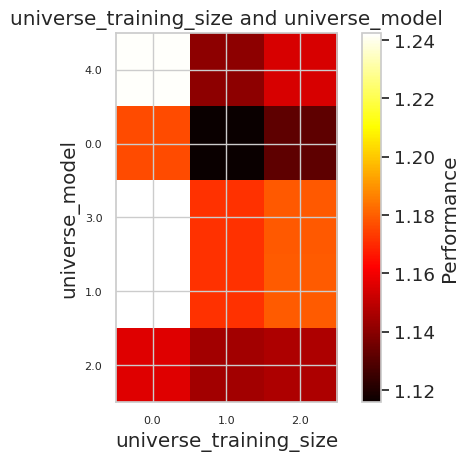

In [22]:
# Plot 2D pairwise marginal
vis.plot_pairwise_marginal(['universe_training_size', 'universe_model'])

In [23]:
# Recover mapping
col = "universe_model"
original_labels = df_agg[col].unique()

# Get corresponding numeric codes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codes = le.fit_transform(df_agg[col].values)
label_map = dict(zip(le.transform(original_labels), original_labels))

# Sort by code
label_map = dict(sorted(label_map.items()))
print(label_map)

{0: 'elasticnet', 1: 'gbm', 2: 'logreg', 3: 'penalized_logreg', 4: 'rf'}


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


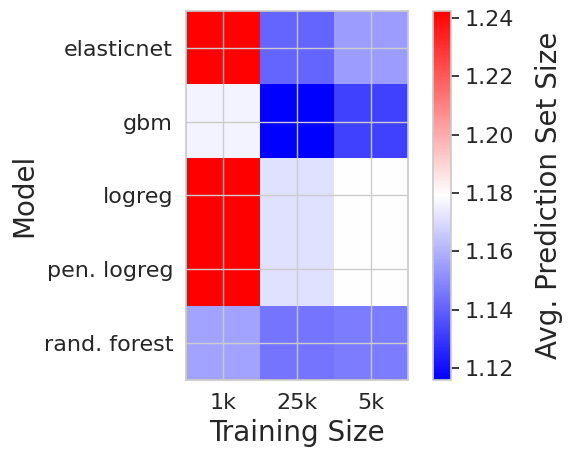

In [33]:
# Heatmap avg. prediction set size

vis.plot_pairwise_marginal(['universe_training_size', 'universe_model'])

plt.yticks(
    ticks=[0,1,2,3,4], 
    labels=['elasticnet', 'gbm', 'logreg', 'pen. logreg', 'rand. forest'], 
    #rotation=45,
    fontsize=16)

plt.xticks(
    ticks=[0,1,2], 
    labels=['1k', '25k', '5k'],
    fontsize=16)

cbar = plt.gcf().axes[-1] 
cbar.set_ylabel("Avg. Prediction Set Size", rotation=90, labelpad=15, fontsize=20)
cbar.tick_params(labelsize=16)

plt.ylabel("Model", fontsize=20)
plt.xlabel("Training Size", fontsize=20)

ax = plt.gca()
im = ax.get_images()[0] 
im.set_cmap("bwr")

plt.title("")
#plt.tight_layout()

output_path = CP_DIR / f"heatmap_{main_cp_metric}.png"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

# Visualizations Conditional Coverage

In [ ]:
# Violin plots conditional coverage

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Label mapping
label_map = {
    'universe_training_size': 'Training Size',
    'universe_training_year': 'Training Year',
    'universe_scale': 'Scaling',
    'universe_model': 'Model',
    'universe_exclude_features': 'Excluded Features',
    'universe_exclude_subgroups': 'Excluded Subgroups'
}

# Custom x-tick renaming
category_renames = {
    '2010_14': '2010-14',
    '2012_14': '2012-14',
    'scale': 'scaled',
    'do-not-scale': 'not-scaled',
    'drop-non-german': 'drop',
    'penalized_logreg': 'pen. logreg',
    'rf': 'rand. forest'
}

# Custom order per parameter
custom_orders = {
    'universe_training_size': ['1k', '5k', '25k'],
    'universe_model': ['logreg', 'penalized_logreg', 'elasticnet', 'gbm', 'rf'],
    'universe_exclude_features': ['none', 'age', 'nationality', 'sex', 'nationality-sex']
}

# Plot layout
row1 = [
    'universe_training_size',
    'universe_training_year',
    'universe_scale',
    'universe_exclude_subgroups'
]
row2 = ['universe_model', 'universe_exclude_features']

widths_row1 = [1.3, 1.3, 1.0, 1.0]
widths_row2 = [2.0, 2.0]

colors_row1 = ['#FFFF99', '#FDBF6F', '#FB9A99', '#CAB2D6']
colors_row2 = ['aquamarine', 'lightskyblue'] 

# Styling
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
fig = plt.figure(figsize=(24, 15))
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.5)

# Font sizes
axis_label_size = 24
tick_label_size = 20
category_label_size = 24

# Row 1
gs_row1 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=4, subplot_spec=outer_gs[0], width_ratios=widths_row1, wspace=0.3
)

for idx, param in enumerate(row1): 
    ax = fig.add_subplot(gs_row1[0, idx]) 

    order = custom_orders.get(param, sorted(df_agg[param].dropna().unique()))
    sns.violinplot(
        data=df_agg, x=param, y='cov_nongerman_female', ax=ax,
        inner='box', cut=0, order=order, color=colors_row1[idx]
    )

    # Overlay median dots
    medians = df_agg.groupby(param)['cov_nongerman_female'].median()
    for i, cat in enumerate(order):
        if cat in medians:
            ax.plot(i, medians[cat], color='lemonchiffon', marker='o', markersize=8, zorder=3)

    # Rename x-tick labels
    xticks = [label.get_text() for label in ax.get_xticklabels()]
    renamed = [category_renames.get(label, label) for label in xticks]
    ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)

    ax.set_xlabel(label_map[param], fontsize=axis_label_size)
    if idx == 0:
        ax.set_ylabel('Cov. Non-German Female', fontsize=axis_label_size)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    ax.set_title("")

# Row 2
gs_row2 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2, subplot_spec=outer_gs[1], width_ratios=widths_row2, wspace=0.1
)
for idx, param in enumerate(row2): 
    ax = fig.add_subplot(gs_row2[0, idx])  

    order = custom_orders.get(param, sorted(df_agg[param].dropna().unique()))
    sns.violinplot(
        data=df_agg, x=param, y='cov_nongerman_female', ax=ax,
        inner='box', cut=0, order=order, color=colors_row2[idx]
    )

    # Overlay median dots
    medians = df_agg.groupby(param)['cov_nongerman_female'].median()
    for i, cat in enumerate(order):
        if cat in medians:
            ax.plot(i, medians[cat], color='lemonchiffon', marker='o', markersize=8, zorder=3)

    # Rename x-tick labels
    xticks = [label.get_text() for label in ax.get_xticklabels()]
    renamed = [category_renames.get(label, label) for label in xticks]
    ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)

    ax.set_xlabel(label_map[param], fontsize=axis_label_size)
    if idx == 0:
        ax.set_ylabel('Cov. Non-German Female', fontsize=axis_label_size)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    ax.set_title("")

output_path = CP_DIR / f"violin_plots_{main_cp_metric}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Recover mapping
col = "universe_scale"
original_labels = df_agg[col].unique()

# Get corresponding numeric codes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codes = le.fit_transform(df_agg[col].values)
label_map = dict(zip(le.transform(original_labels), original_labels))

# Sort by code
label_map = dict(sorted(label_map.items()))
print(label_map)

In [ ]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(CP_DIR))

In [ ]:
# Plot 2D pairwise marginal
vis.plot_pairwise_marginal(['universe_scale', 'universe_model'])

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


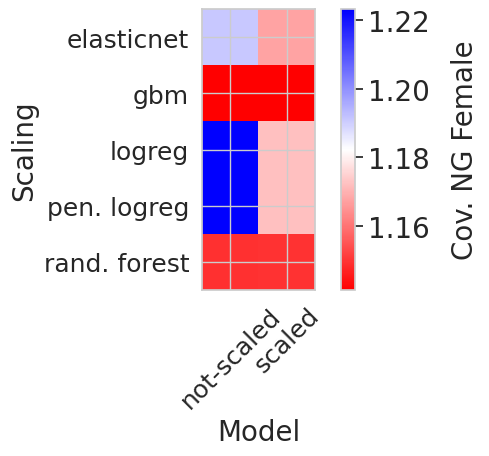

In [26]:
# Heatmap conditional coverage

import matplotlib.pyplot as plt

vis.plot_pairwise_marginal(['universe_scale', 'universe_model'])

plt.yticks(
    ticks=[0,1,2,3,4], 
    labels=['elasticnet', 'gbm', 'logreg', 'pen. logreg', 'rand. forest'], 
    fontsize=18)

plt.xticks(
    ticks=[0,1], 
    labels=['not-scaled', 'scaled'],
    rotation=45,
    fontsize=18)

cbar = plt.gcf().axes[-1] 
cbar.set_ylabel("Cov. NG Female", rotation=90, labelpad=15, fontsize=20)
cbar.tick_params(labelsize=20)

plt.xlabel("Model", fontsize=20)
plt.ylabel("Scaling", fontsize=20)

ax = plt.gca()
im = ax.get_images()[0] 
im.set_cmap("bwr_r")


plt.title("")
plt.tight_layout()

output_path = CP_DIR / f"heatmap_{main_cp_metric}.png"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

## Quantify Importance with Partial Data

In [ ]:
from tqdm import tqdm

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [ ]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df[main_cp_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)